# Setup & Imports

This cell sets up the Python environment and imports all necessary libraries and modules.

- Adds the parent directory to Python path to enable imports from `algorithms/` and `problems/`
- Imports essential libraries: numpy, matplotlib, time, csv, tracemalloc
- Configures matplotlib for inline display in Jupyter
- Imports all optimization algorithms (PSO, ABC, FA, CS, GA, HC) and the Rastrigin problem function


In [1]:
import sys
import os

# Add parent directory (project root) to Python path
# This allows notebook in /notebooks to import from /algorithms and /problems
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import tracemalloc

# Configure matplotlib for inline display in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

# Import optimization algorithms
from algorithms import pso, abc, fa, cs, ga, hc
from problems.rastrigin import rastrigin

print("✓ Imports successful!")
print(f"✓ Working directory: {os.getcwd()}")
print(f"✓ Module path added: {module_path}")


✓ Imports successful!
✓ Working directory: /mnt/d/02_University_HCMUS/Year_3/Sem_5/04_Intro2AI/algorithm/notebooks
✓ Module path added: /mnt/d/02_University_HCMUS/Year_3/Sem_5/04_Intro2AI/algorithm


# Configuration

Define all experiment parameters including:
- Number of runs for statistical averaging
- Problem dimensions to test
- Population size and maximum iterations
- Algorithm-specific parameters for each optimization method


In [2]:
# Common parameters
N_RUNS = 10  # Number of runs for averaging
DIMENSIONS = [10, 30]  # Scalability test dimensions
POP_SIZE = 50  # Population size
MAX_ITER = 50  # Maximum number of iterations

# Algorithm-specific parameters
ALGO_PARAMS = {
    'pso': {'w': 0.8, 'c1': 2.0, 'c2': 2.0},
    'abc': {'limit': 10},
    'fa': {'alpha': 0.5, 'beta0': 1.0, 'gamma': 0.95},
    'cs': {'pa': 0.25, 'beta': 1.5},
    'ga': {'crossover_rate': 0.8, 'mutation_rate': 0.02},
    'hc': {'step_size': 0.1}
}

ALGOS = {
    'PSO': pso.pso_continuous,
    'ABC': abc.abc_continuous,
    'FA': fa.firefly_continuous,
    'CS': cs.cuckoo_search_continuous,
    'GA': ga.genetic_continuous,
    'HC': hc.hill_climbing_continuous
}

print("=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"N_RUNS = {N_RUNS}")
print(f"DIMENSIONS = {DIMENSIONS}")
print(f"POP_SIZE = {POP_SIZE}")
print(f"MAX_ITER = {MAX_ITER}")
print(f"Algorithms: {list(ALGOS.keys())}")
print("=" * 60)


CONFIGURATION
N_RUNS = 10
DIMENSIONS = [10, 30]
POP_SIZE = 50
MAX_ITER = 50
Algorithms: ['PSO', 'ABC', 'FA', 'CS', 'GA', 'HC']


# Run Experiments

Execute all optimization algorithms on the Rastrigin function for each dimension.

This cell:
- Runs each algorithm N_RUNS times for statistical reliability
- Tracks convergence history, fitness values, execution time, and memory usage
- Computes summary statistics (mean, std, min, max) for each algorithm
- Stores data in memory for visualization and saving


In [3]:
# Experiment script
results_summary = []  # Store summary results
convergence_data = {}  # Store convergence history
raw_fitness_data = {}  # Store raw data for box plots

print("=" * 60)
print("RASTRIGIN FUNCTION OPTIMIZATION EXPERIMENTS")
print("=" * 60)
print(f"Settings: N_RUNS={N_RUNS}, POP_SIZE={POP_SIZE}, MAX_ITER={MAX_ITER}")
print("=" * 60)

for D in DIMENSIONS:
    print(f"\n{'='*60}")
    print(f"Running experiments for D={D}")
    print(f"{'='*60}")
    
    bounds = np.array([[-5.12, 5.12]] * D)
    convergence_data[D] = {}
    raw_fitness_data[D] = {}
    
    for algo_name, algo_func in ALGOS.items():
        print(f"\n[{algo_name}] Starting {N_RUNS} runs...")
        run_histories = []
        run_fitnesses = []
        run_times = []
        run_memories = []
        
        for r in range(N_RUNS):
            # Start memory tracing
            tracemalloc.start()
            start_time = time.time()
            
            # All algorithms use _continuous functions
            # HC doesn't need pop_size parameter
            if algo_name == 'HC':
                sol, fit, hist = algo_func(rastrigin, bounds, D, MAX_ITER, **ALGO_PARAMS['hc'])
            else:
                sol, fit, hist = algo_func(rastrigin, bounds, D, POP_SIZE, MAX_ITER, 
                                          **ALGO_PARAMS[algo_name.lower()])
            
            elapsed = time.time() - start_time
            # Get peak memory usage (in MB)
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            peak_mem_mb = peak / 1024 / 1024  # Convert bytes to MB
            
            run_times.append(elapsed)
            run_fitnesses.append(fit)
            run_histories.append(hist)
            run_memories.append(peak_mem_mb)
            
            if (r + 1) % 5 == 0:
                print(f"  Run {r+1}/{N_RUNS} completed. Best fitness: {fit:.4f}")
        
        # Calculate statistics
        avg_fit = np.mean(run_fitnesses)
        std_fit = np.std(run_fitnesses)
        min_fit = np.min(run_fitnesses)
        max_fit = np.max(run_fitnesses)
        avg_time = np.mean(run_times)
        avg_peak_mem = np.mean(run_memories)
        
        print(f"[{algo_name}] Completed!")
        print(f"  Avg Fitness: {avg_fit:.4f} ± {std_fit:.4f}")
        print(f"  Min Fitness: {min_fit:.4f}")
        print(f"  Max Fitness: {max_fit:.4f}")
        print(f"  Avg Time: {avg_time:.4f}s")
        print(f"  Avg Peak Memory: {avg_peak_mem:.4f} MB")
        
        results_summary.append([algo_name, D, avg_fit, std_fit, min_fit, max_fit, avg_time, avg_peak_mem])
        
        # Store average convergence history
        # Pad histories to same length if needed
        max_len = max(len(h) for h in run_histories)
        padded_histories = []
        for h in run_histories:
            if len(h) < max_len:
                # Pad with last value
                padded = list(h) + [h[-1]] * (max_len - len(h))
            else:
                padded = h
            padded_histories.append(padded)
        
        avg_convergence = np.mean(np.array(padded_histories), axis=0)
        convergence_data[D][algo_name] = avg_convergence
        
        # Save raw fitness data for box plots
        raw_fitness_data[D][algo_name] = run_fitnesses

print(f"\n{'='*60}")
print("EXPERIMENTS COMPLETED!")
print(f"{'='*60}")


RASTRIGIN FUNCTION OPTIMIZATION EXPERIMENTS
Settings: N_RUNS=10, POP_SIZE=50, MAX_ITER=50

Running experiments for D=10

[PSO] Starting 10 runs...
  Run 5/10 completed. Best fitness: 32.9435
  Run 10/10 completed. Best fitness: 33.5674
[PSO] Completed!
  Avg Fitness: 35.3604 ± 5.9508
  Min Fitness: 25.7677
  Max Fitness: 45.0668
  Avg Time: 0.1103s
  Avg Peak Memory: 0.0178 MB

[ABC] Starting 10 runs...
  Run 5/10 completed. Best fitness: 15.7141
  Run 10/10 completed. Best fitness: 19.8569
[ABC] Completed!
  Avg Fitness: 13.7752 ± 3.6848
  Min Fitness: 8.8773
  Max Fitness: 20.1858
  Avg Time: 0.4442s
  Avg Peak Memory: 0.0153 MB

[FA] Starting 10 runs...
  Run 5/10 completed. Best fitness: 86.1763
  Run 10/10 completed. Best fitness: 84.5457
[FA] Completed!
  Avg Fitness: 80.5989 ± 7.5749
  Min Fitness: 68.3480
  Max Fitness: 91.4814
  Avg Time: 3.1924s
  Avg Peak Memory: 0.0135 MB

[CS] Starting 10 runs...
  Run 5/10 completed. Best fitness: 40.3124
  Run 10/10 completed. Best fitne

# Save Results to CSV

Save all experiment results to CSV files for later analysis and reporting.

This cell creates three CSV files:
- `rastrigin_summary.csv`: Summary statistics (mean, std, min, max fitness, time, memory)
- `rastrigin_convergence.csv`: Convergence history for each algorithm and dimension
- `rastrigin_raw_fitness.csv`: Raw fitness values from all runs for robustness analysis


In [4]:
# Save results to CSV files
results_dir = os.path.join('..', 'results')
os.makedirs(results_dir, exist_ok=True)

print(f"{'='*60}")
print("Saving results to CSV files...")
print(f"{'='*60}")

# Summary file
summary_file = os.path.join(results_dir, 'rastrigin_summary.csv')
with open(summary_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Algorithm', 'Dimension', 'Avg_Fitness', 'Std_Dev_Fitness', 
                     'Min_Fitness', 'Max_Fitness', 'Avg_Time', 'Avg_Peak_Mem_MB'])
    writer.writerows(results_summary)
print(f"✓ Summary saved to: {summary_file}")

# Convergence file
convergence_file = os.path.join(results_dir, 'rastrigin_convergence.csv')
with open(convergence_file, 'w', newline='') as f:
    writer = csv.writer(f)
    # Write header
    header = ['Iteration'] + [f"{algo}_D{D}" for D in DIMENSIONS for algo in ALGOS.keys()]
    writer.writerow(header)
    # Write data
    max_iters = max(len(convergence_data[D][algo]) for D in DIMENSIONS for algo in ALGOS.keys())
    for i in range(max_iters):
        row = [i]
        for D in DIMENSIONS:
            for algo in ALGOS.keys():
                if i < len(convergence_data[D][algo]):
                    row.append(convergence_data[D][algo][i])
                else:
                    row.append(convergence_data[D][algo][-1])
        writer.writerow(row)
print(f"✓ Convergence data saved to: {convergence_file}")

# Raw fitness data for box plots
rawdata_file = os.path.join(results_dir, 'rastrigin_raw_fitness.csv')
with open(rawdata_file, 'w', newline='') as f:
    writer = csv.writer(f)
    # Header
    header = ['Run'] + [f"{algo}_D{D}" for D in DIMENSIONS for algo in ALGOS.keys()]
    writer.writerow(header)
    # Data
    for run in range(N_RUNS):
        row = [run + 1]
        for D in DIMENSIONS:
            for algo in ALGOS.keys():
                row.append(raw_fitness_data[D][algo][run])
        writer.writerow(row)
print(f"✓ Raw fitness data saved to: {rawdata_file}")

print(f"\n{'='*60}")
print("All CSV files saved successfully!")
print(f"{'='*60}")


Saving results to CSV files...
✓ Summary saved to: ../results/rastrigin_summary.csv
✓ Convergence data saved to: ../results/rastrigin_convergence.csv
✓ Raw fitness data saved to: ../results/rastrigin_raw_fitness.csv

All CSV files saved successfully!


# Visualization: Convergence Curves

Plot convergence curves showing how each algorithm's best fitness improves over iterations.

- Displays convergence for all algorithms on the same plot for easy comparison
- Uses log scale on y-axis for better visualization of wide fitness ranges
- Saves plots to `results/convergence/` directory
- Displays plots inline in the notebook


✓ Saved: ../results/convergence/convergence_rastrigin_D10.png


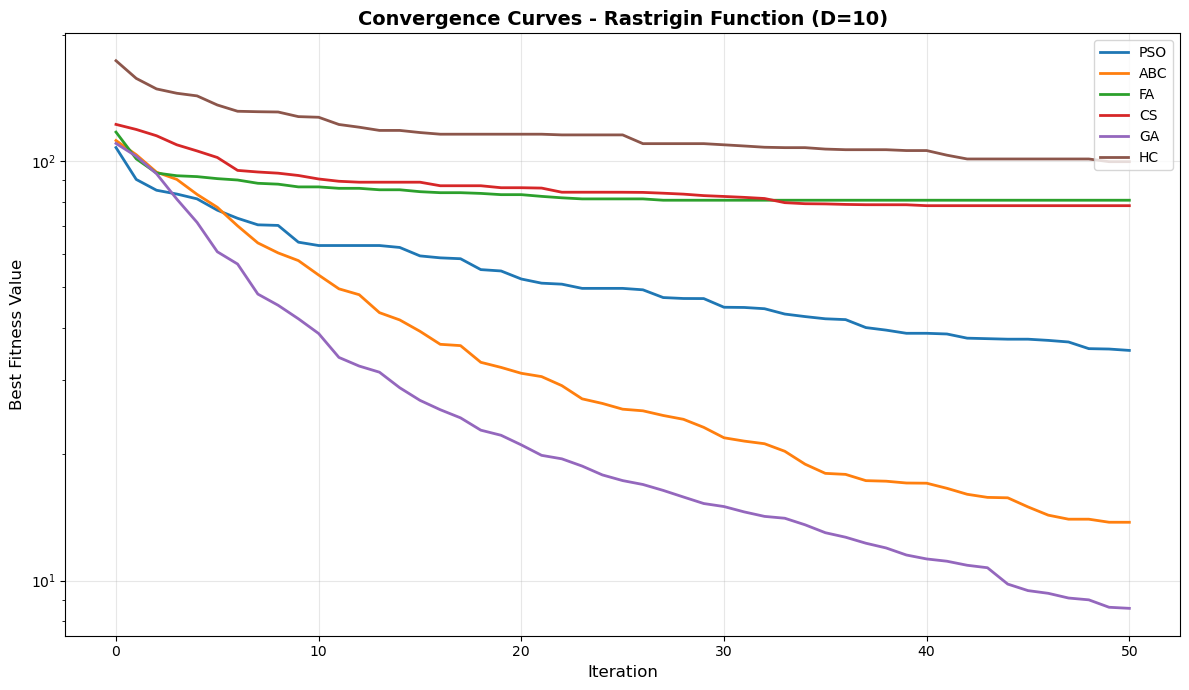

✓ Saved: ../results/convergence/convergence_rastrigin_D30.png


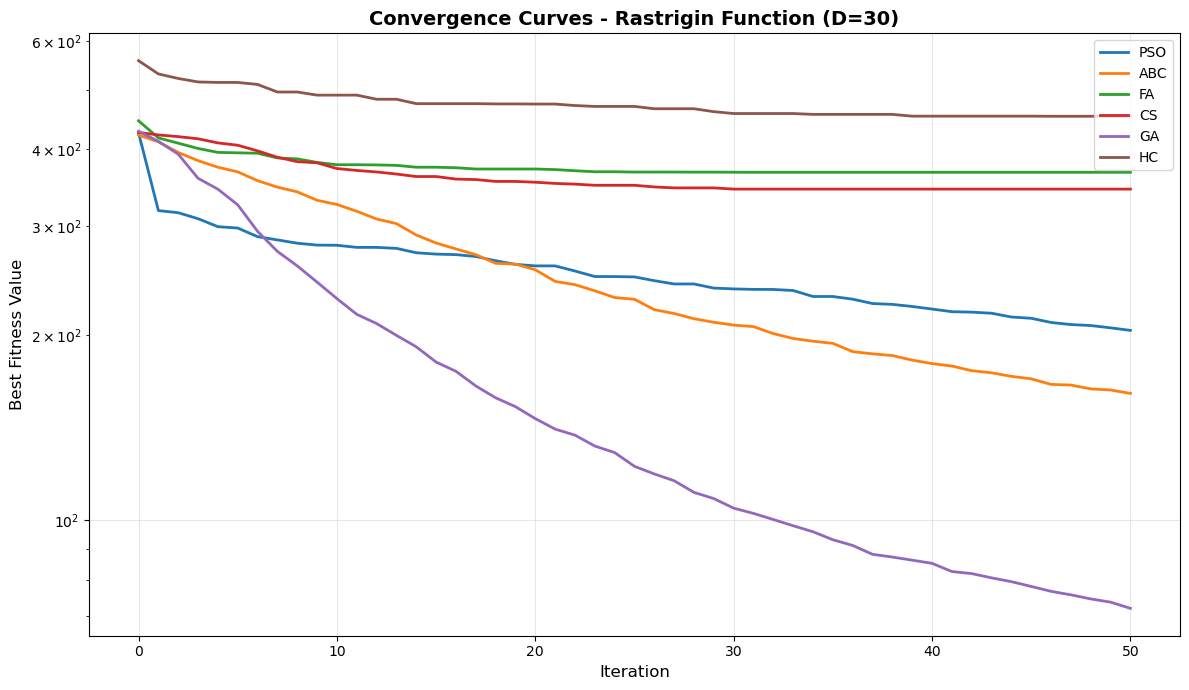

In [5]:
# Color scheme
colors = {
    'PSO': '#1f77b4',
    'ABC': '#ff7f0e',
    'FA': '#2ca02c',
    'CS': '#d62728',
    'GA': '#9467bd',
    'HC': '#8c564b'
}

algorithms = ['PSO', 'ABC', 'FA', 'CS', 'GA', 'HC']

# Create plots for each dimension
for D in DIMENSIONS:
    fig, ax = plt.subplots(figsize=(12, 7))

    for algo in algorithms:
        if algo in convergence_data[D]:
            ax.plot(convergence_data[D][algo], label=algo,
                   linewidth=2, color=colors[algo])

    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Best Fitness Value', fontsize=12)
    ax.set_title(f'Convergence Curves - Rastrigin Function (D={D})', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # Log scale for better visualization

    # Save figure
    results_output_dir = os.path.join('..', 'results', 'convergence')
    os.makedirs(results_output_dir, exist_ok=True)
    output_file = os.path.join(results_output_dir, f'convergence_rastrigin_D{D}.png')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_file}")
    
    # Display in notebook
    plt.show()


# Visualization: Robustness (Box Plots)

Create box plots to analyze algorithm robustness and stability across multiple runs.

- Shows distribution of fitness values from all runs
- Displays median (red line) and mean (blue dashed line)
- Helps identify algorithms with consistent performance vs. high variance
- Saves plots to `results/robustness/` directory


✓ Saved: ../results/robustness/robustness_rastrigin_D10.png


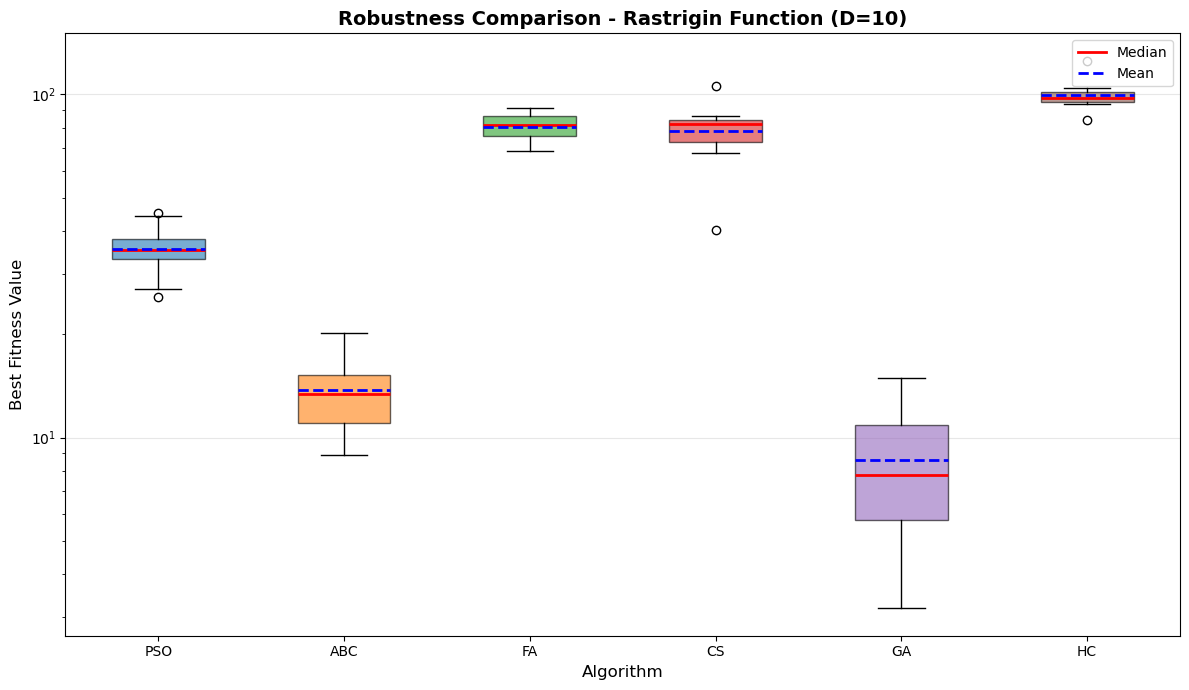

✓ Saved: ../results/robustness/robustness_rastrigin_D30.png


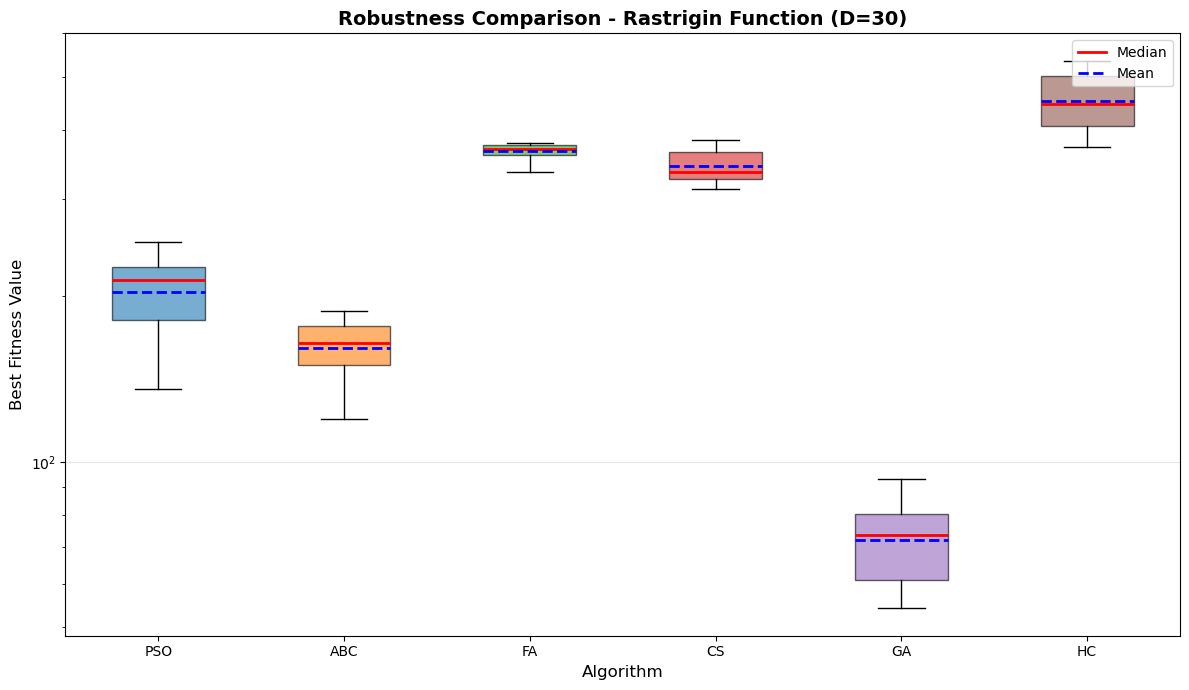

In [6]:
# Color scheme
colors = {
    'PSO': '#1f77b4',
    'ABC': '#ff7f0e',
    'FA': '#2ca02c',
    'CS': '#d62728',
    'GA': '#9467bd',
    'HC': '#8c564b'
}

algorithms = ['PSO', 'ABC', 'FA', 'CS', 'GA', 'HC']

# Create box plots for each dimension
for D in DIMENSIONS:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Prepare data for box plot
    plot_data = []
    labels = []
    box_colors = []

    for algo in algorithms:
        if algo in raw_fitness_data[D]:
            plot_data.append(raw_fitness_data[D][algo])
            labels.append(algo)
            box_colors.append(colors[algo])

    # Create box plot
    bp = ax.boxplot(plot_data, patch_artist=True,
                    showmeans=True, meanline=True,
                    medianprops=dict(color='red', linewidth=2),
                    meanprops=dict(color='blue', linewidth=2, linestyle='--'))
    # Set tick labels
    ax.set_xticklabels(labels)

    # Color the boxes
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    ax.set_xlabel('Algorithm', fontsize=12)
    ax.set_ylabel('Best Fitness Value', fontsize=12)
    ax.set_title(f'Robustness Comparison - Rastrigin Function (D={D})',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_yscale('log')  # Log scale for better visualization

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', linewidth=2, label='Median'),
        Line2D([0], [0], color='blue', linewidth=2,
               linestyle='--', label='Mean')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

    # Save figure
    results_output_dir = os.path.join('..', 'results', 'robustness')
    os.makedirs(results_output_dir, exist_ok=True)
    output_file = os.path.join(results_output_dir, f'robustness_rastrigin_D{D}.png')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_file}")
    
    # Display in notebook
    plt.show()


# Visualization: Complexity Analysis

Analyze computational complexity by comparing execution time and memory usage across algorithms.

- Time complexity: Bar chart showing average execution time per algorithm
- Memory complexity: Bar chart showing average peak memory usage per algorithm
- Helps identify trade-offs between solution quality and computational cost
- Saves plots to `results/complexity/` directory


✓ Saved: ../results/complexity/complexity_rastrigin_D10.png


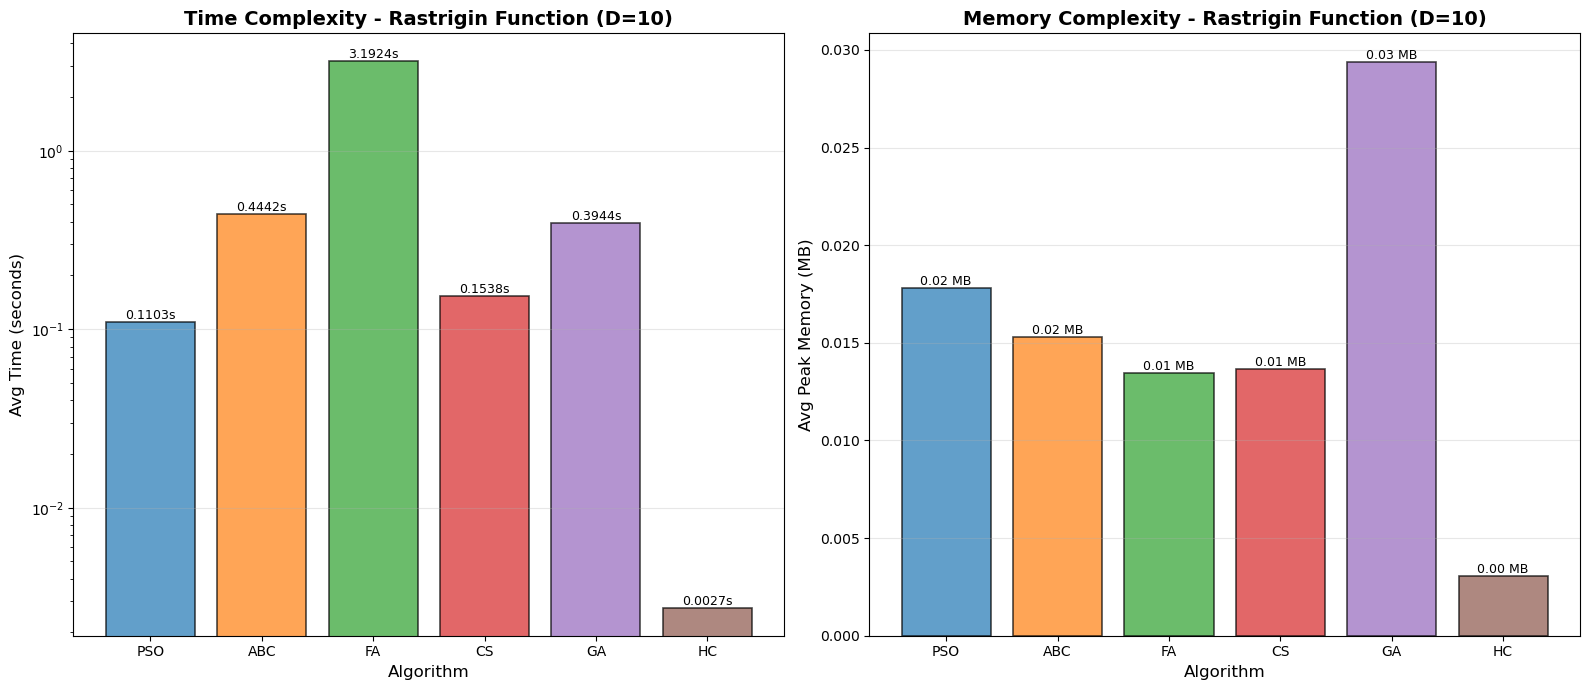

✓ Saved: ../results/complexity/complexity_rastrigin_D30.png


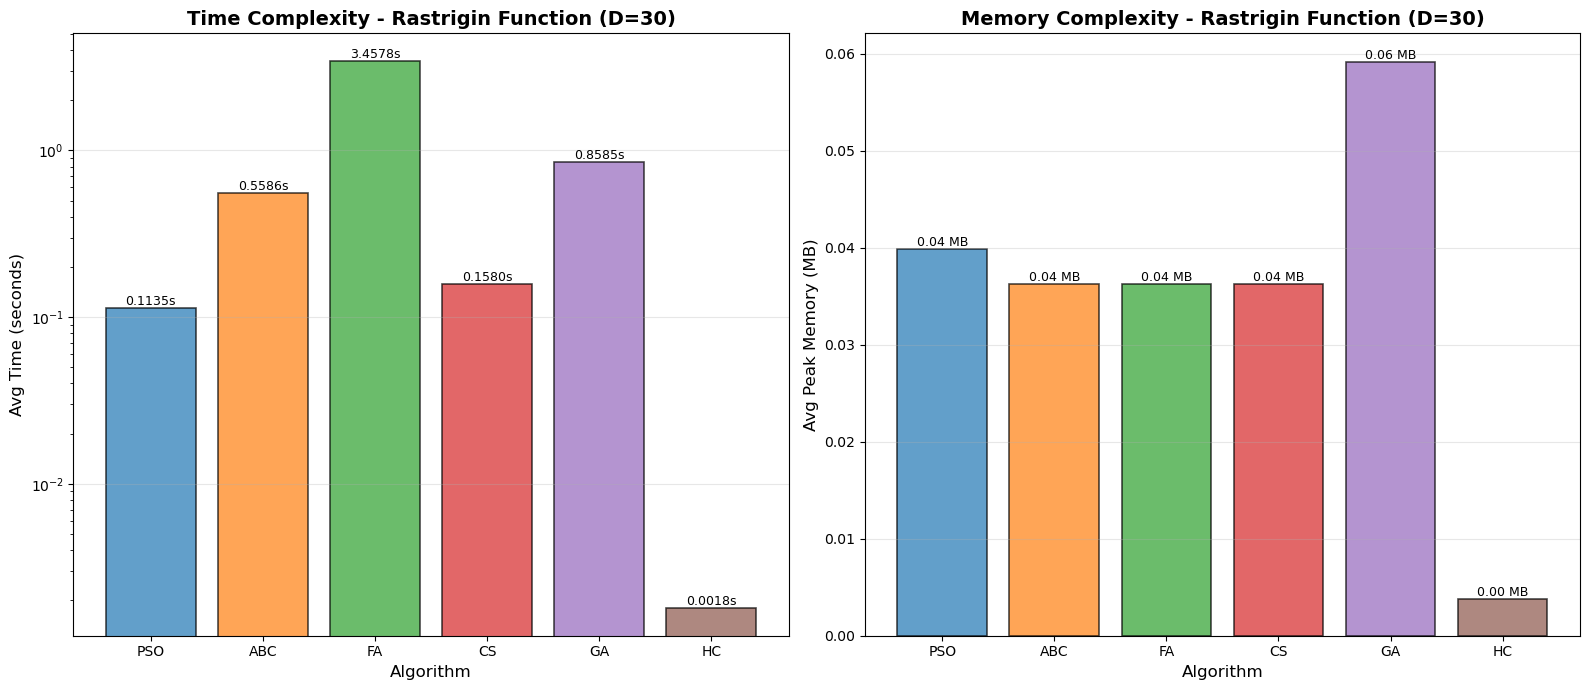

In [7]:
# Color scheme
colors = {
    'PSO': '#1f77b4',
    'ABC': '#ff7f0e',
    'FA': '#2ca02c',
    'CS': '#d62728',
    'GA': '#9467bd',
    'HC': '#8c564b'
}

algorithms = ['PSO', 'ABC', 'FA', 'CS', 'GA', 'HC']

# Create plots for each dimension
for D in DIMENSIONS:
    # Prepare data for bar charts
    algo_names = []
    times = []
    memories = []
    bar_colors = []

    # Extract data from results_summary
    for entry in results_summary:
        if entry[1] == D:  # entry[1] is Dimension
            algo = entry[0]  # entry[0] is Algorithm
            if algo in algorithms:
                algo_names.append(algo)
                times.append(entry[6])  # entry[6] is Avg_Time
                memories.append(entry[7])  # entry[7] is Avg_Peak_Mem_MB
                bar_colors.append(colors[algo])

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # --- Time Complexity Bar Chart ---
    bars1 = ax1.bar(algo_names, times, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.2)
    ax1.set_xlabel('Algorithm', fontsize=12)
    ax1.set_ylabel('Avg Time (seconds)', fontsize=12)
    ax1.set_title(f'Time Complexity - Rastrigin Function (D={D})',
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_yscale('log')  # Log scale for better visualization

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}s',
                ha='center', va='bottom', fontsize=9)

    # --- Memory Complexity Bar Chart ---
    bars2 = ax2.bar(algo_names, memories, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.2)
    ax2.set_xlabel('Algorithm', fontsize=12)
    ax2.set_ylabel('Avg Peak Memory (MB)', fontsize=12)
    ax2.set_title(f'Memory Complexity - Rastrigin Function (D={D})',
                  fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f} MB',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()

    # Save figure
    results_output_dir = os.path.join('..', 'results', 'complexity')
    os.makedirs(results_output_dir, exist_ok=True)
    output_file = os.path.join(results_output_dir, f'complexity_rastrigin_D{D}.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_file}")
    
    # Display in notebook
    plt.show()


# Visualization: Time vs Fitness Trade-off

Analyze the trade-off between computational time and solution quality using scatter plots.

- Each algorithm is represented as a point in the time-fitness space
- X-axis: Average execution time (log scale)
- Y-axis: Average fitness value (log scale)
- Helps identify algorithms that balance speed and quality
- Saves plots to `results/tradeoff/` directory


✓ Saved: ../results/tradeoff/tradeoff_rastrigin_D10.png


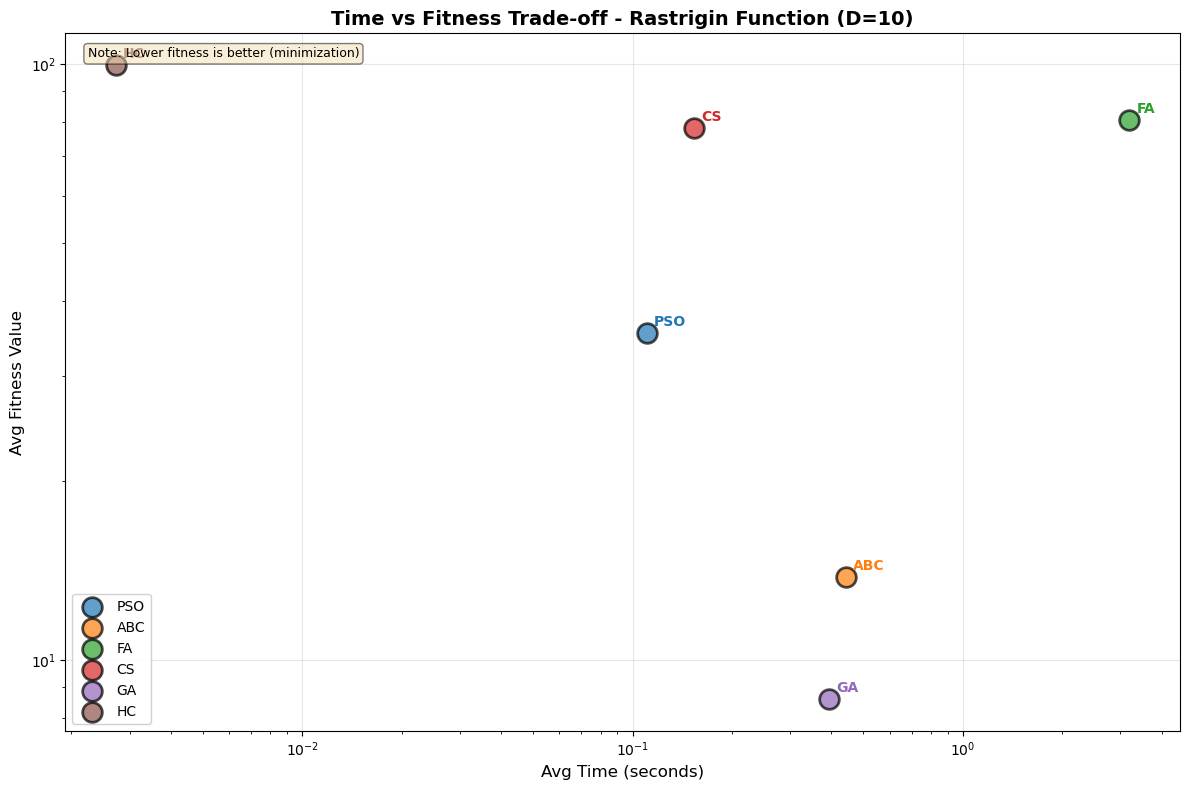

✓ Saved: ../results/tradeoff/tradeoff_rastrigin_D30.png


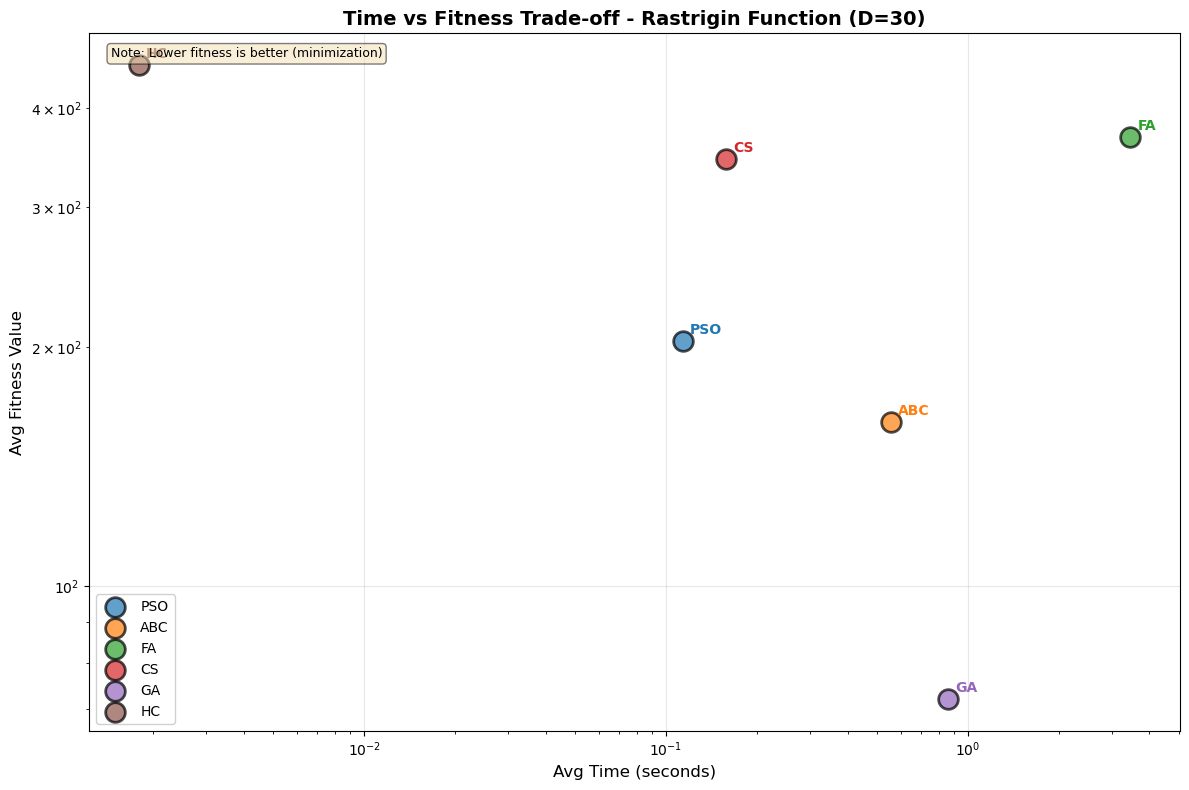

In [8]:
# Color scheme
colors = {
    'PSO': '#1f77b4',
    'ABC': '#ff7f0e',
    'FA': '#2ca02c',
    'CS': '#d62728',
    'GA': '#9467bd',
    'HC': '#8c564b'
}

algorithms = ['PSO', 'ABC', 'FA', 'CS', 'GA', 'HC']

# Prepare data from results_summary
data = {}
for entry in results_summary:
    algo = entry[0]  # Algorithm
    dim = entry[1]   # Dimension
    avg_fitness = entry[2]  # Avg_Fitness
    avg_time = entry[6]    # Avg_Time
    
    key = f"{algo}_D{dim}"
    if key not in data:
        data[key] = {'algo': algo, 'dim': dim, 'fitness': avg_fitness, 'time': avg_time}

# Create plots for each dimension
for D in DIMENSIONS:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each algorithm as a point
    for algo in algorithms:
        key = f"{algo}_D{D}"
        if key in data:
            x = data[key]['time']
            y = data[key]['fitness']
            ax.scatter(x, y, s=200, color=colors[algo], alpha=0.7,
                      edgecolors='black', linewidth=2, label=algo, zorder=3)
            # Add algorithm label near the point
            ax.annotate(algo, (x, y), xytext=(5, 5), textcoords='offset points',
                       fontsize=10, fontweight='bold', color=colors[algo])

    ax.set_xlabel('Avg Time (seconds)', fontsize=12)
    ax.set_ylabel('Avg Fitness Value', fontsize=12)
    ax.set_title(f'Time vs Fitness Trade-off - Rastrigin Function (D={D})',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')  # Log scale for time (better visualization)
    ax.set_yscale('log')  # Log scale for fitness (better visualization)

    # Add legend
    ax.legend(loc='best', fontsize=10, framealpha=0.9)

    # Add note about optimization direction
    ax.text(0.02, 0.98, 'Note: Lower fitness is better (minimization)',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()

    # Save figure
    results_output_dir = os.path.join('..', 'results', 'tradeoff')
    os.makedirs(results_output_dir, exist_ok=True)
    output_file = os.path.join(results_output_dir, f'tradeoff_rastrigin_D{D}.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_file}")
    
    # Display in notebook
    plt.show()
